In [1]:
using local_POD_overlap.module_2D

using LinearAlgebra
using Plots
using LaTeXStrings
using ProgressBars

import LinearAlgebra.eigvals 
using Statistics
using Random
using Distributions
using SparseArrays

### 

# Code plan

## - Code energy-preserving discretization
## - Randomly generate turbulent velocity fields
## - Do a pressure projection on the velocity fields
## - Run the simulation 
## - Implement local POD with overlap
## - Implement projection
## - Test POD approaches

In [106]:
N = (200,200)
UPC = 1       


x= collect(LinRange(-pi,pi,N[1]+1))
y = collect(LinRange(-pi,pi,N[2]+1))

fine_mesh = gen_mesh(x,y,UPC = UPC,use_GPU = false)

# number of unknowns per cell

J = (25,25) # compression in each direction
coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh,J)
MP = gen_mesh_pair(fine_mesh,coarse_mesh)
0



0

In [107]:
eta(x) = exp.(-(x)/(x*(1-x)))

eta (generic function with 1 method)

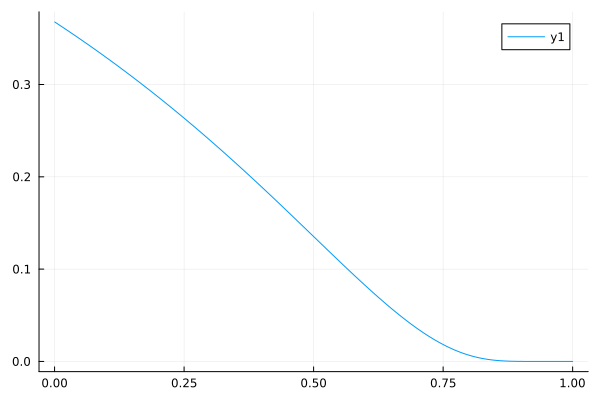

In [108]:
plot(collect(LinRange(0,1,3000)),eta.( collect(LinRange(0,1,3000))))

In [109]:
function f1(x)

    return (1 .- x[1]) .* (1 .- x[2])
end

function f2(x)

    return (x[1]) .* (1 .- x[2])
end
function f3(x)

    return x[1] .* x[2]
end
function f4(x)

    return (1 .- x[1]) .* x[2]
end


function bilinear_kernel(x)

    m1 = (x[1] .< 0) .* (x[2] .< 0)
    
    m2 = (x[1] .>= 0) .* (x[2] .< 0)
    m3 = (x[1] .< 0) .* (x[2] .>= 0) 
    m4 = (x[1] .>= 0) .* (x[2] .>= 0)

    
    x1,y1 = x[1] .+ 1, x[2] .+ 1
    x2,y2 = x[1] , x[2] .+ 1
    x3,y3 = x[1] .+ 1, x[2] 
    x4,y4 = x[1] , x[2] 

    

    

    

    f1 = (x1 ) .* (y1)
    f2 = (1 .- x2 ) .* ( y2 )
    f3 = (x3 ) .* (1 .- y3  )
    f4 = (1 .- x4) .* (1 .- y4)


    return m1 .* f1 .+ m2 .* f2 .+ m3 .* f3 .+ m4 .* f4
    #return m3
end


function mollifier_bump_kernel(x)

    m1 = (x[1] .< 0) .* (x[2] .< 0)
    
    m2 = (x[1] .>= 0) .* (x[2] .< 0)
    m3 = (x[1] .< 0) .* (x[2] .>= 0) 
    m4 = (x[1] .>= 0) .* (x[2] .>= 0)


    x1,y1 = x[1] .+ 1, x[2] .+ 1
    x2,y2 = x[1] , x[2] .+ 1
    x3,y3 = x[1] .+ 1, x[2] 
    x4,y4 = x[1] , x[2] 

    delta = 1e-10
    ## circumvent the NaN at x = 0
    x1,y1 = max.(x1,delta), max.(y1,delta)
    x2,y2 = max.(x2,delta), max.(y2,delta)
    x3,y3 = max.(x3,delta), max.(y3,delta)
    x4,y4 = max.(x4,delta), max.(y4,delta)

    
    eta(x) = exp.(-(x)/(x*(1-x)))

    eta_tilde(x) = eta(x)/(eta(x)+eta(1-x))
    a(x) = eta_tilde(x)
    b(x) = 1 -a(x)
    
    f1 = b.(x1) .* b.(y1)
    f2 = a.(x2) .* b.(y2)
    f3 = b.(x3) .* a.(y3)
    f4 = a.(x4) .* a.(y4)


    return m1 .* f1 .+ m2 .* f2 .+ m3 .* f3 .+ m4 .* f4
    #return m3
end



mollifier_bump_kernel (generic function with 1 method)

In [110]:
J =  4 .* MP.J
x= collect(LinRange(-1,1,J[1]+1))
y = collect(LinRange(-1,1,J[2]+1))

full_filter_mesh = gen_mesh(x,y,UPC = UPC,use_GPU = false)
full_filter_mesh.x
0

0

In [111]:
test = full_filter_mesh.eval_function(mollifier_bump_kernel)

100×100×1×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0  0.0          0.0          0.0          …  0.0          0.0
 0.0  8.69719e-29  5.50747e-23  1.70791e-20     8.72837e-29  9.52626e-58
 0.0  5.50747e-23  3.48759e-17  1.08153e-14     5.52721e-23  6.03248e-52
 0.0  1.70791e-20  1.08153e-14  3.35391e-12     1.71403e-20  1.87072e-49
 0.0  4.18237e-19  2.64847e-13  8.21313e-11     4.19736e-19  4.58106e-48
 0.0  3.23131e-18  2.04622e-12  6.34548e-10  …  3.24289e-18  3.53934e-47
 0.0  1.3413e-17   8.49375e-12  2.63398e-9      1.34611e-17  1.46916e-46
 0.0  3.833e-17    2.42724e-11  7.52706e-9      3.84674e-17  4.19839e-46
 0.0  8.59491e-17  5.4427e-11   1.68783e-8      8.62572e-17  9.41423e-46
 0.0  1.63092e-16  1.03278e-10  3.20272e-8      1.63677e-16  1.78639e-45
 0.0  2.74404e-16  1.73765e-10  5.3886e-8    …  2.75387e-16  3.00562e-45
 0.0  4.22045e-16  2.67259e-10  8.28791e-8      4.23558e-16  4.62277e-45
 0.0  6.05894e-16  3.83681e-10  1.18982e-7      6.08066e-16  6.63652e-45
 ⋮           

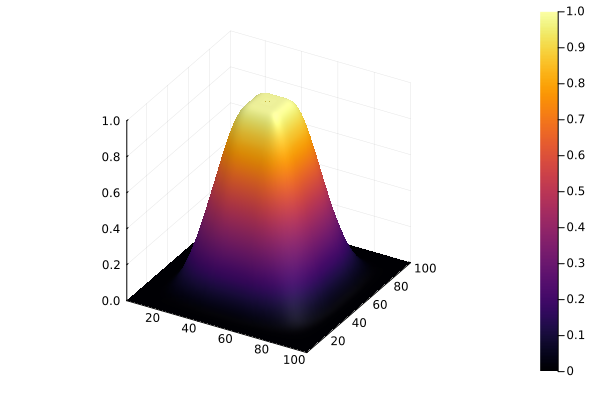

In [112]:
surface(test[:,:,1,1])

In [113]:
dummy_data = gen_random_field(fine_mesh.N,10, samples = (1,20))

200×200×1×20 Array{Float64, 4}:
[:, :, 1, 1] =
 0.704348  0.673636  0.651924  0.642446  …  0.8016    0.773889  0.739556
 0.820507  0.774988  0.741002  0.722672     0.9656    0.922666  0.871943
 0.964656  0.904648  0.858172  0.830218     1.15398   1.0974    1.03152
 1.1267    1.0526    0.993546  0.955369     1.35682   1.28804   1.20817
 1.29412   1.20634   1.13472   1.08588      1.56204   1.48225   1.38942
 1.45282   1.35175   1.26765   1.20789   …  1.75623   1.66631   1.56133
 1.58822   1.4742    1.37774   1.3069       1.9256    1.82606   1.70946
 1.68633   1.5596    1.45091   1.36897      2.05704   1.94799   1.82001
 1.73486   1.59555   1.47475   1.38177      2.13912   2.02029   1.88089
 1.72419   1.57235   1.43954   1.33565      2.16296   2.03377   1.88267
 1.64825   1.48385   1.33913   1.22448   …  2.12299   1.98266   1.81938
 1.50509   1.32806   1.1715    1.04629      2.0175    1.86512   1.68913
 1.29718   1.10747   0.939159  0.803576     1.84883   1.68356   1.49437
 ⋮             

In [114]:
function overlap_shifter(data,overlap_MP;index = 3,forward = true)


    shift_x, shift_y = Int.(round.(1/2 .* overlap_MP.J))

    if forward
        shifted_x = circshift( data,(shift_x,0))
        shifted_y = circshift( data,(0,shift_y))
        shifted_x_y = circshift( data,(shift_x,shift_y))
    else
        shifted_x = circshift( data,(-shift_x,0))
        shifted_y = circshift( data,(0,-shift_y))
        shifted_x_y = circshift( data,(-shift_x,-shift_y))


    end
    
    indexes = collect(1:size(data)[index])
    shifted_indexes_x = indexes .+ size(data)[index]
    shifted_indexes_y = indexes .+ 2*size(data)[index]
    shifted_indexes_x_y = indexes .+ 3*size(data)[index]

    indexes = cat(indexes,shifted_indexes_x,shifted_indexes_y,shifted_indexes_x_y,dims = 2)'[1:end]
    
    modes = cat(data,shifted_x,shifted_y,shifted_x_y,dims = index)
    
    return modes[[(:) for i in 1:index-1]...,indexes,[(:) for i in 1:(length(size(modes))-index)]...]
end

function carry_out_local_SVD_overlap_2D_periodic_only(input,MP)

    UPC = MP.fine_mesh.UPC
    dims = MP.fine_mesh.dims
    
    overlap_fine_mesh = MP.fine_mesh
    overlap_coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh, 2 .* MP.J)
    overlap_MP = gen_mesh_pair(overlap_fine_mesh,overlap_coarse_mesh)
    
    kernel_x= collect(LinRange(-1,1,overlap_MP.J[1]+1))
    kernel_y = collect(LinRange(-1,1,overlap_MP.J[2]+1))

    kernel_mesh = gen_mesh(kernel_x,kernel_y,UPC = UPC,use_GPU = false)
    kernel = kernel_mesh.eval_function(mollifier_bump_kernel)

    input =  overlap_shifter(input,overlap_MP,index = 4)
    reshaped_input = kernel .* reshape_for_local_SVD(input,overlap_MP,subtract_average = false)
    

    vector_input = reshape(reshaped_input,(prod(size(reshaped_input)[1:end-1]),size(reshaped_input)[end]))

    SVD = svd(vector_input)

    return  reshape(SVD.U,(overlap_MP.J...,UPC,Int(size(SVD.U)[end]))),SVD.S,overlap_MP
end




    

carry_out_local_SVD_overlap_2D_periodic_only (generic function with 1 method)

In [115]:

modes,S = carry_out_local_SVD(dummy_data,MP)
overlap_modes,overlap_S,overlap_MP = carry_out_local_SVD_overlap_2D_periodic_only(dummy_data,MP)

([-1.877455361928315e-16 8.33807205008384e-20 … 0.0 0.0; -1.0593334649141724e-17 2.7330370027298994e-17 … 5.372189474037754e-17 9.20522923203596e-32; … ; 2.2472508543595328e-20 6.685458566796284e-17 … -1.1397604262069652e-17 -6.290414048366345e-32; 2.881177415101026e-20 -1.4309394870504468e-23 … -1.4559528922147876e-31 -5.467897085386565e-46;;;; -1.0190114843438346e-16 2.3056522164401046e-19 … 0.0 0.0; -8.729627810883491e-17 3.2638871375988383e-16 … 2.3357212539023463e-16 7.419441738900264e-31; … ; 3.757263046353619e-20 -5.9934758744315615e-18 … -6.891643098691109e-17 -1.7861555652788254e-31; 1.410281421987719e-20 -1.2547909594755135e-23 … -1.364317088776521e-31 -2.5289886408047826e-46;;;; -2.222573595564025e-17 1.2091227956794914e-19 … 0.0 0.0; 6.569437173549154e-18 2.4222107320987204e-16 … -8.617987192029813e-17 -2.4559588839088317e-31; … ; 1.9430898453139188e-19 2.0521787836577696e-16 … -1.3641703985941468e-16 -3.453006100287882e-31; -9.455888731554094e-20 9.895383004667127e-24 … -3

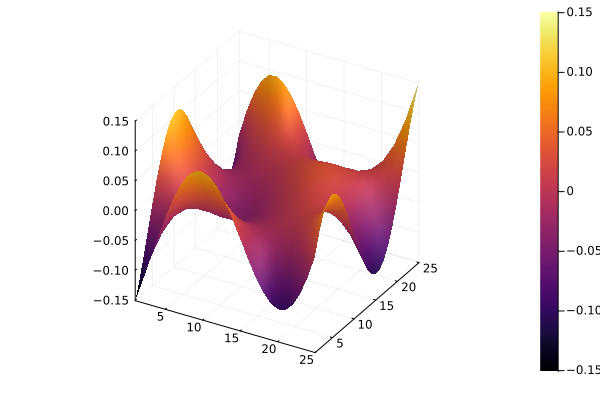

In [116]:
surface(modes[:,:,1,15])

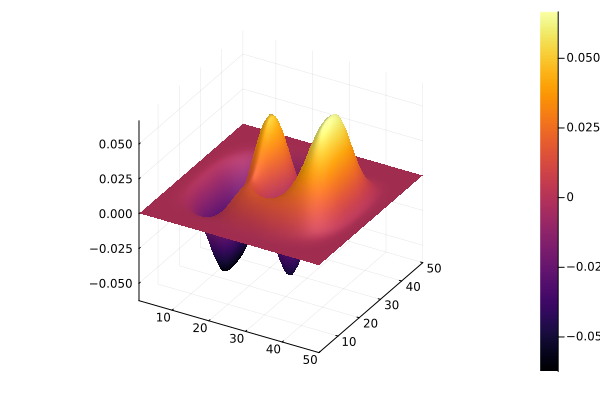

In [131]:
surface(overlap_modes[:,:,1,10])

In [118]:
function local_to_global_modes_overlap_2D_periodic_only(overlap_modes,overlap_MP)
    overlap_global_modes = local_to_global_modes(overlap_modes,overlap_MP)

    shift_x, shift_y = Int.(round.(1/2 .* overlap_MP.J))
    
    shifted_x = circshift( overlap_global_modes,(shift_x,0))
    shifted_y = circshift( overlap_global_modes,(0,shift_y))
    
    shifted_x_y = circshift( overlap_global_modes,(shift_x,shift_y))
    dims = overlap_MP.fine_mesh.dims
    modes = cat(overlap_global_modes,shifted_x,shifted_y,shifted_x_y,dims = dims +2)
    indexes = collect(1:size(overlap_global_modes)[end])
    shifted_indexes_x = indexes .+ size(overlap_global_modes)[end]
    shifted_indexes_y = indexes .+ 2*size(overlap_global_modes)[end]
    shifted_indexes_x_y = indexes .+ 3*size(overlap_global_modes)[end]

    indexes = cat(indexes,shifted_indexes_x,shifted_indexes_y,shifted_indexes_x_y,dims = 2)'[1:end]
    #return modes[:,:,:,indexes]
    return overlap_shifter(overlap_global_modes,overlap_MP,index = 4)
end


local_to_global_modes_overlap_2D_periodic_only (generic function with 1 method)

In [119]:
heatmap(overlap_global_modes[:,:,1,1])

LoadError: UndefVarError: `overlap_global_modes` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [120]:
heatmap(global_modes[:,:,1,1])

LoadError: UndefVarError: `global_modes` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# Generating POD operators

In [157]:
struct overlap_projection_operators_struct
    Phi_T
    Phi
    S_inv
end

function generate_ROM_operator(input_dimension,proj_FOM_rhs)

    dummy_vec = zeros(input_dimension)

    
    
    ROM_operator = zeros((input_dimension...,input_dimension...))

    for i in 1:input_dimension[1]
        test_vec = copy(dummy_vec)
        test_vec[i] += 1

        
        result = proj_FOM_rhs(test_vec)
        #output = reshape(,shape_2)

        ROM_operator[i,:] .+= result

    end
    
    return sparsify_matrix(ROM_operator)
end

function sparsify_matrix(A,tolerance = 1e-10)
    B = spzeros(size(A))
    for i in 1:size(A)[1]
        for j in 1:size(A)[2]
            if abs(A[i,j]) >= tolerance
                B[i,j] += A[i,j]
            end
        end
    end
    return B
end

function generate_S(overlap_MP,Phi_T,Phi)

    dummy_input = zeros(overlap_MP.fine_mesh.N...,1,1)
    dummy_vec = 0 * Phi_T(dummy_input)

    shape_1 = size(dummy_vec)
    shape_2 = (prod(shape_1),)

    dummy_vec = reshape(dummy_vec,shape_2)
    
    
    S = zeros((shape_2[1],shape_2[1]))

    for i in 1:shape_2[1]
        test_vec = copy(dummy_vec)
        test_vec[i] += 1

        test_vec = reshape(test_vec,shape_1)

        corresponding_state = Phi(test_vec)
        corresponding_coefficients = Phi_T(corresponding_state)
        overlap = reshape(corresponding_coefficients,shape_2)
        
        #output = reshape(,shape_2)

        S[i,:] .+= overlap

    end
    
    return sparsify_matrix(S)
end


function gen_projection_operators_overlap_2D_periodic_only(overlap_modes,overlap_MP)
    PO = gen_projection_operators(overlap_modes,overlap_MP)
    
    function Phi_T(input,PO = PO,overlap_MP = overlap_MP)
        


        dims = overlap_MP.fine_mesh.dims
        shift_x, shift_y = Int.(round.(1/2 .* overlap_MP.J))

        output_1 = PO.Phi_T(input)
        output_2 = PO.Phi_T(circshift(input,(shift_x,0)))
        output_3 = PO.Phi_T(circshift(input,(0,shift_y)))
        output_4 = PO.Phi_T(circshift(input,(shift_x,shift_y)))

        indexes = collect(1:size(output_1)[dims+1])
        shifted_indexes_x = indexes .+ size(output_1)[dims+1]
        shifted_indexes_y = indexes .+ 2*size(output_1)[dims+1]
        shifted_indexes_x_y = indexes .+ 3*size(output_1)[dims+1]
    
        indexes = cat(indexes,shifted_indexes_x,shifted_indexes_y,shifted_indexes_x_y,dims = 2)'[1:end]
    
        
        output = cat(output_1,output_2,output_3,output_4,dims = dims + 1)

        return output[:,:,indexes,:]
        return input
    end

    function Phi(input,PO = PO,overlap_MP = overlap_MP)

        dims = overlap_MP.fine_mesh.dims
        
        shift_x, shift_y = Int.(round.(1/2 .* overlap_MP.J))
        
        number_of_modes = size(input)[dims+1]
        unique_modes = Int(round(number_of_modes/4))
        index_1 = 4 * collect(0:unique_modes-1) .+ 1 
        index_2 = index_1 .+ 1
        index_3 = index_1 .+ 2
        index_4 = index_1 .+ 3


        output_1 = PO.Phi(input[:,:,index_1,:]) 
        output_2 = circshift(PO.Phi(input[:,:,index_2,:]),(-shift_x,0) )
        output_3 = circshift(PO.Phi(input[:,:,index_3,:]),(0,-shift_y)) 
        output_4 = circshift(PO.Phi(input[:,:,index_4,:]),(-shift_x,-shift_y)) 
        
       
        return output_1 .+ output_2 .+ output_3 .+ output_4
    end

    S = generate_S(overlap_MP,Phi_T,Phi)
    inv_S = inv(Matrix(S))
    
    function S_inv(input,S = S, inv_S = inv_S)

        shape_1 = size(input)
        shape_2 = (prod(shape_1[1:end-1]),shape_1[end])

        reshaped_input = reshape(input,shape_2)
        solved = inv_S * reshaped_input
        #solved = solve(S,reshaped_input)
        output = reshape(solved,shape_1)
        
        
        return output


    end 

    
    return overlap_projection_operators_struct(Phi_T,Phi,S_inv)
end


r = 10

PO = gen_projection_operators(modes[:,:,:,1:r],MP)
overlap_PO = gen_projection_operators_overlap_2D_periodic_only(overlap_modes[:,:,:,1:r],overlap_MP)
S = generate_S(overlap_MP,overlap_PO.Phi_T,overlap_PO.Phi)

640×640 SparseMatrixCSC{Float64, Int64} with 57600 stored entries:
⎡⣵⣿⣿⣿⣷⣿⣿⣿⣷⣷⣿⣿⣷⣷⣿⣿⣷⣷⣿⣿⣷⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⎤
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⢽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⢽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⢽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢕⢕⣿⣿⢽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣗⎥
⎢⢽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣗⣿⣿⢕⢕⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣗⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣗⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣗⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎣⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⢿⣿⣿⢿⢿⣿⣿⢿⢿⣿⣿⢿⢿⣿⣿⣿⢿⣿⣿⣿⢟⎦

In [174]:
r = 10

function compute_L2(a;average = true)
    if average
        return mean(sqrt.(sum(a.^2,dims = [1,2])))
    else
        return sqrt.(sum(a.^2,dims = [1,2]))
    end
end

rs = 1:20
local_errors = []
overlap_errors = []

for r in rs

    local_PO = gen_projection_operators(modes[:,:,:,1:r],MP)
    overlap_PO = gen_projection_operators_overlap_2D_periodic_only(overlap_modes[:,:,:,1:r],overlap_MP)
    #S = generate_S(overlap_MP,overlap_PO.Phi_T,overlap_PO.Phi)
    
    overlap_a = overlap_PO.Phi_T(dummy_data)
    solved = overlap_PO.S_inv(overlap_a)
    overlap_u_r = overlap_PO.Phi(solved)

    local_a = local_PO.Phi_T(dummy_data)
    local_u_r = local_PO.Phi(local_a)

    local_error = compute_L2(dummy_data - local_u_r)
    overlap_error = compute_L2(dummy_data - overlap_u_r)

    push!(local_errors,local_error)
    push!(overlap_errors,overlap_error)

end

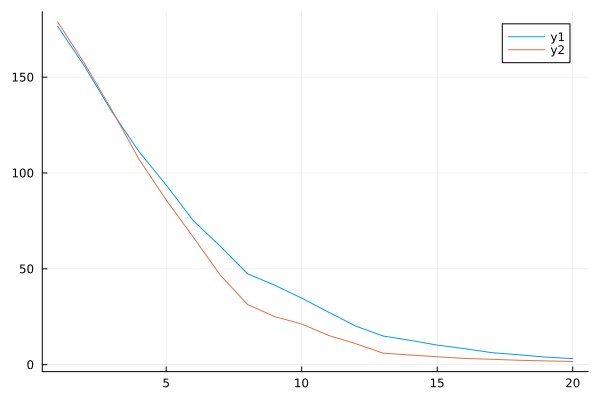

In [175]:
plot(local_errors)
plot!(overlap_errors)

In [172]:
heatmap(overlap_u_r[:,:,1,1])

LoadError: UndefVarError: `overlap_u_r` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

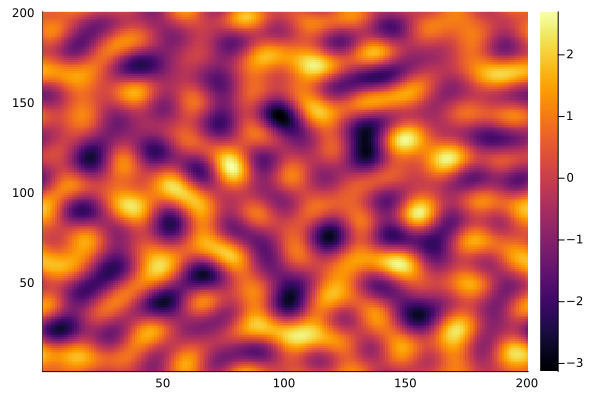

In [173]:
heatmap(dummy_data[:,:,1,1])

In [125]:

x= collect(LinRange(-pi,pi,N[1]+1))
y = collect(LinRange(-pi,pi,N[2]+1))

velocity_mesh = gen_mesh(x,y,UPC = 2,use_GPU = false)

setup = gen_setup(velocity_mesh)

u0_f(x) = 2*pi* sin.(x[2]) .* cos.(x[1])
v0_f(x) = -2*pi* sin.(x[1]) .* cos.(x[2])

u0 = velocity_mesh.eval_function(u0_f)
v0 = velocity_mesh.eval_function(v0_f)

V0 = cat(u0,v0,dims = 3)[:,:,:,:]
V0 = project_divergence(V0,setup)
w0 = setup.O.w(V0)

198×198×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
 -12.524   -12.4962  -12.456   -12.4036  …  -12.4777  -12.5117  -12.5333
 -12.4962  -12.4684  -12.4283  -12.376      -12.45    -12.4839  -12.5055
 -12.456   -12.4283  -12.3884  -12.3362     -12.41    -12.4438  -12.4653
 -12.4036  -12.376   -12.3362  -12.2842     -12.3577  -12.3914  -12.4128
 -12.3389  -12.3114  -12.2718  -12.2201     -12.2933  -12.3268  -12.3481
 -12.262   -12.2347  -12.1954  -12.144   …  -12.2167  -12.25    -12.2712
 -12.173   -12.1459  -12.1069  -12.0559     -12.1281  -12.1611  -12.1821
 -12.072   -12.0452  -12.0064  -11.9558     -12.0275  -12.0602  -12.0811
 -11.9591  -11.9325  -11.8941  -11.844      -11.915   -11.9474  -11.9681
 -11.8344  -11.8081  -11.7701  -11.7205     -11.7908  -11.8229  -11.8433
 -11.698   -11.672   -11.6344  -11.5854  …  -11.6549  -11.6866  -11.7068
 -11.5501  -11.5244  -11.4873  -11.4389     -11.5075  -11.5389  -11.5588
 -11.3907  -11.3654  -11.3288  -11.2811     -11.3488  -11.3797  -11.3993
   ⋮ 

In [126]:
setup.O.M(V0)

198×198×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
 -1.72604f-6   1.58043f-6  -1.56285f-6  …  -1.70077f-7  -7.28056f-8
  1.73619f-6  -2.35572f-6  -1.79312f-7      6.34794f-7   1.29205f-6
  1.83837f-7  -1.93089f-6   2.45737f-6     -3.22174f-8  -5.15803f-7
  1.55148f-6   1.20238f-6  -2.04653f-6     -1.96666f-6   4.95601f-7
 -3.52339f-6  -4.2862f-6    3.45794f-6      6.26999f-7   2.573f-6
  2.31058f-7   6.37164f-6  -3.96479f-6  …   1.9491f-6   -1.27616f-8
 -4.4793f-6    5.32319f-7   5.80286f-6      5.56545f-6  -3.61527f-6
  2.89616f-6  -1.23338f-6  -1.14383f-7     -2.32573f-6   8.72024f-7
  7.85215f-7   6.06415f-6  -1.5084f-6       2.29836f-6  -5.34019f-7
  9.25495f-6  -3.28435f-6   2.41291f-6      5.13225f-6  -6.8398f-6
 -5.33554f-6   5.60371f-6  -2.97829f-6  …  -9.03138f-7   1.61881f-6
 -8.32525f-6   2.59993f-6   1.67977f-5      3.57427f-6  -1.45177f-6
  7.86111f-6   2.8687f-6   -7.01819f-6      3.1307f-6   -8.8713f-7
  ⋮                                     ⋱               
 -6.02459f-6  -1.

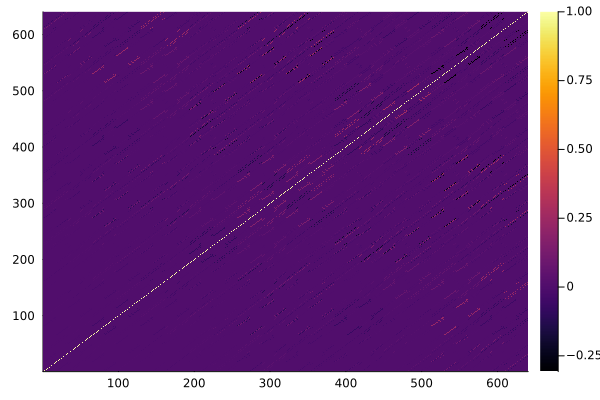

In [128]:
heatmap(S)